In [2]:
import pandas as pd
import json
pd.set_option("display.max_rows",None)
pd.set_option("display.max_columns",None)

In [81]:
import numpy as np

import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,roc_auc_score, roc_curve,accuracy_score,precision_score,f1_score,precision_recall_curve
from xgboost import XGBClassifier
import matplotlib.pyplot as plt


In [77]:
dir(metrics)

['ConfusionMatrixDisplay',
 'DetCurveDisplay',
 'DistanceMetric',
 'PrecisionRecallDisplay',
 'RocCurveDisplay',
 'SCORERS',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_base',
 '_classification',
 '_dist_metrics',
 '_pairwise_distances_reduction',
 '_pairwise_fast',
 '_plot',
 '_ranking',
 '_regression',
 '_scorer',
 'accuracy_score',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'auc',
 'average_precision_score',
 'balanced_accuracy_score',
 'brier_score_loss',
 'calinski_harabasz_score',
 'check_scoring',
 'classification_report',
 'cluster',
 'cohen_kappa_score',
 'completeness_score',
 'confusion_matrix',
 'consensus_score',
 'coverage_error',
 'd2_absolute_error_score',
 'd2_pinball_score',
 'd2_tweedie_score',
 'davies_bouldin_score',
 'dcg_score',
 'det_curve',
 'euclidean_distances',
 'explained_variance_score',
 'f1_score',
 'fbeta_score',
 'fowlkes_mallows_score',
 'get

#### Import Data

In [4]:
# Enquiry Data

f = open('enquiry_data_train.json')
  
# returns JSON object as 
# a dictionary
data = json.load(f)

unq_lst=[]

for val in data:
    unq_lst.extend(val)
    

enquiry_data_train=pd.json_normalize(unq_lst)

In [5]:
enquiry_data_train.head()


,enquiry_type,enquiry_amt,enquiry_date,uid
0,Interbank credit,168839,2020-11-08,AAA08065248
1,Mobile operator loan,268392,2020-09-20,AAA08065248
2,Mobile operator loan,36082,2020-06-19,AAA08065248
3,Interbank credit,180467,2019-10-22,AAA08065248
4,Cash loan (non-earmarked),227459,2020-05-24,AAA08065248


In [6]:
# Accounts Data Train

f = open('accounts_data_train.json')
  
# returns JSON object as 
# a dictionary
data_accounts = json.load(f)

unq_lst_accounts=[]

for val in data_accounts:
    unq_lst_accounts.extend(val)
    
accounts_data_train=pd.json_normalize(unq_lst_accounts)

In [7]:
# Training population and flags

train_flag=pd.read_csv('train_flag.csv')

## Functions

In [8]:
# Converting default information to 0,1 flags

def default_mnth_history(a):
    mnth_default=''
    for i in range(len(a)//3):
        if a[3*i:3*(i+1)]=='000': 
            mnth_default=mnth_default+'0'
        else:
            mnth_default=mnth_default+'1'
    return mnth_default
    
    

### Preprocessing

In [ ]:
# Making  features around credit history

# closed_fg-Whether a loan is closed or not: 1 if loan is closed else 0
accounts_data_train['closed_fg']=(~accounts_data_train['closed_date'].isna()).astype(int)
accounts_data_train['closed_fg']=accounts_data_train['closed_fg'].astype(str)
accounts_data_train['closed_fg']=np.where(accounts_data_train['closed_fg']=='0',"open","closed")

# pct_due- % Overdue for each loan =(amount_overdue*100/loan_amount)
accounts_data_train['pct_due']=accounts_data_train['amount_overdue']*100/accounts_data_train['loan_amount']


# Type Casting to date time
accounts_data_train['open_date_1']=pd.to_datetime(accounts_data_train['open_date'])
accounts_data_train['closed_date_1']=pd.to_datetime(accounts_data_train['closed_date'])
accounts_data_train['closed_date_1']=pd.to_datetime(accounts_data_train['closed_date'])




### EDA

In [251]:
train_flag['NAME_CONTRACT_TYPE'].unique()

array(['Cash loans', 'Revolving loans'], dtype=object)

In [252]:
train_flag['uid'].nunique()

261383

In [253]:
# Event Rate
train_flag['TARGET'].sum()*100/len(train_flag['TARGET']) # 8.05599446023651

# Loan Disbursed are unique
train_flag['uid'].nunique()==train_flag['uid'].shape[0] # True

#
train_flag['uid'].shape[0] #261383


261383

In [254]:
# Credit History of 85% Loans Disbursed is present
train_flag_merged=train_flag.merge(accounts_data_train,how='left',on='uid')
train_flag_merged[train_flag_merged.credit_type.notna()]['uid'].nunique()*100/train_flag['uid'].shape[0]

85.66662713336369

In [255]:
# Credit History of 86% of Good Loans Disbursed is present
train_flag_merged[(train_flag_merged.TARGET==0) & (train_flag_merged.credit_type.notna())]['uid'].nunique()*100/len(train_flag[train_flag.TARGET==0])

85.99194427569219

In [256]:
# Credit History of 82% of Bad Loans Disbursed is present
train_flag_merged[(train_flag_merged.TARGET==1) & (train_flag_merged.credit_type.notna())]['uid'].nunique()*100/len(train_flag[train_flag.TARGET==1])

81.95374459799592

### Feature Preparation using Accounts Data

In [257]:
# default_mnths_pct-% months member has defaulted in loan repayment period
# default_mnths_pct-% months member has defaulted in last 6 months of loan repayment period

accounts_data_train['default_mnth_history']=accounts_data_train['payment_hist_string'].apply(lambda x : default_mnth_history(x))
accounts_data_train['default_mnths_pct']=accounts_data_train.default_mnth_history.str.count('1')*100/(accounts_data_train.default_mnth_history.str.len())
accounts_data_train['default_mnths_pct_recent']=accounts_data_train.default_mnth_history.apply(lambda x : x[len(x)-6:].count('1')*100/max(min(len(x),6),1))





accounts_data_train['prev_loan_default'] = accounts_data_train.sort_values(by=['open_date'], ascending=True)\
                       .groupby(['uid'])['amount_overdue'].shift(1)


# Feature for Loan Closure date
accounts_data_train['diff_days']=accounts_data_train['closed_date_1']-accounts_data_train['open_date_1']

# Feature for how many days before today - Loan was opened
accounts_data_train['relationship_period']=pd.to_datetime('today')-accounts_data_train['open_date_1']



In [258]:
# Creating binary variable for loan type

accounts_data_train['value']=1

dummies_accounts_data=accounts_data_train.pivot_table(values='value',index='uid',aggfunc='max',columns='credit_type').reset_index()

In [259]:
# Augmenting column names for differtiating between feature from loan vs enquiry- 
# _loan features are coming from loan data
cols=[]

cols_aug=[i+'_loan' for i in dummies_accounts_data.columns]

dummies_accounts_data.columns=cols_aug

In [260]:
## feature for days difference between oldest loan and current date approved for a member

rln_period=accounts_data_train.groupby('uid').aggregate({'relationship_period':max}).reset_index()

rln_period.relationship_period=rln_period.relationship_period.apply(lambda x : x.days )

In [261]:
accounts_data_train['closed_fg'].unique()

array(['closed', 'open'], dtype=object)

In [262]:
# Features for closed vs open loan amounts,amount_overdue no of loans taken, 
# % months defaulted over payment period, % months defaulted over last 6 months
# Difference between open and closed days

accounts_data_train_grouped=accounts_data_train.groupby(['uid','closed_fg']).aggregate({'loan_amount':sum,'amount_overdue':sum,'open_date':'count','default_mnths_pct':'max','default_mnths_pct_recent':'max','diff_days':'mean'})

accounts_data_train_grouped.diff_days=accounts_data_train_grouped.diff_days.apply(lambda x : x.days )

# Bringing closed flag to columns 
accounts_data_train_grouped=accounts_data_train_grouped.unstack('closed_fg')

# Renaming Columns due to problems caused by multi level columns
accounts_data_train_grouped.columns=["_".join(x) for x in accounts_data_train_grouped ]

accounts_data_train_grouped=accounts_data_train_grouped.reset_index()

In [263]:
accounts_data_train_grouped.head()

,uid,loan_amount_closed,loan_amount_open,amount_overdue_closed,amount_overdue_open,open_date_closed,open_date_open,default_mnths_pct_closed,default_mnths_pct_open,default_mnths_pct_recent_closed,default_mnths_pct_recent_open,diff_days_closed,diff_days_open
0,AAA09044550,277245.0,NaN,0.0,NaN,2.0,NaN,12.5,NaN,0.0,NaN,511.0,NaN
1,AAA10545297,NaN,80996.445,NaN,0.0,NaN,1.0,NaN,0.000000,NaN,0.000000,NaN,NaN
2,AAA14112888,43771.5,NaN,0.0,NaN,1.0,NaN,0.0,NaN,0.0,NaN,92.0,NaN
3,AAA20326915,489496.5,102100.500,0.0,0.0,5.0,3.0,0.0,40.789474,0.0,33.333333,387.0,NaN
4,AAA31604840,346810.5,1245150.000,0.0,0.0,2.0,3.0,0.0,0.000000,0.0,0.000000,463.0,NaN


In [264]:
# Loan Amount Features
loan_amt_features=accounts_data_train.groupby(['uid','credit_type','closed_fg']).aggregate({'loan_amount':sum,'open_date':'count','default_mnths_pct':'mean','default_mnths_pct_recent':'mean'})

loan_amt_features=loan_amt_features.unstack(['credit_type','closed_fg']).reset_index()

loan_amt_features.columns=["_".join(x) for x in loan_amt_features.columns]

loan_amt_features.rename(columns = {'uid__':'uid'
                              
                              
                             }, inplace = True)

In [265]:
loan_amt_features.head()

,uid,loan_amount_Consumer credit_closed,loan_amount_Credit card_open,loan_amount_Consumer credit_open,loan_amount_Credit card_closed,loan_amount_Mortgage_closed,loan_amount_Car loan_closed,loan_amount_Car loan_open,loan_amount_Loan for business development_closed,loan_amount_Mortgage_open,loan_amount_Microloan_open,loan_amount_Another type of loan_closed,loan_amount_Loan for working capital replenishment_open,loan_amount_Microloan_closed,loan_amount_Loan for business development_open,loan_amount_Unknown type of loan_open,loan_amount_Another type of loan_open,loan_amount_Loan for working capital replenishment_closed,loan_amount_Unknown type of loan_closed,loan_amount_Loan for the purchase of equipment_closed,loan_amount_Real estate loan_open,loan_amount_Real estate loan_closed,loan_amount_Cash loan (non-earmarked)_open,loan_amount_Loan for purchase of shares (margin lending)_open,loan_amount_Loan for purchase of shares (margin lending)_closed,loan_amount_Cash loan (non-earmarked)_closed,loan_amount_Interbank credit_closed,loan_amount_Loan for the purchase of equipment_open,loan_amount_Mobile operator loan_open,open_date_Consumer credit_closed,open_date_Credit card_open,open_date_Consumer credit_open,open_date_Credit card_closed,open_date_Mortgage_closed,open_date_Car loan_closed,open_date_Car loan_open,open_date_Loan for business development_closed,open_date_Mortgage_open,open_date_Microloan_open,open_date_Another type of loan_closed,open_date_Loan for working capital replenishment_open,open_date_Microloan_closed,open_date_Loan for business development_open,open_date_Unknown type of loan_open,open_date_Another type of loan_open,open_date_Loan for working capital replenishment_closed,open_date_Unknown type of loan_closed,open_date_Loan for the purchase of equipment_closed,open_date_Real estate loan_open,open_date_Real estate loan_closed,open_date_Cash loan (non-earmarked)_open,open_date_Loan for purchase of shares (margin lending)_open,open_date_Loan for purchase of shares (margin lending)_closed,open_date_Cash loan (non-earmarked)_closed,open_date_Interbank credit_closed,open_date_Loan for the purchase of equipment_open,open_date_Mobile operator loan_open,default_mnths_pct_Consumer credit_closed,default_mnths_pct_Credit card_open,default_mnths_pct_Consumer credit_open,default_mnths_pct_Credit card_closed,default_mnths_pct_Mortgage_closed,default_mnths_pct_Car loan_closed,default_mnths_pct_Car loan_open,default_mnths_pct_Loan for business development_closed,default_mnths_pct_Mortgage_open,default_mnths_pct_Microloan_open,default_mnths_pct_Another type of loan_closed,default_mnths_pct_Loan for working capital replenishment_open,default_mnths_pct_Microloan_closed,default_mnths_pct_Loan for business development_open,default_mnths_pct_Unknown type of loan_open,default_mnths_pct_Another type of loan_open,default_mnths_pct_Loan for working capital replenishment_closed,default_mnths_pct_Unknown type of loan_closed,default_mnths_pct_Loan for the purchase of equipment_closed,default_mnths_pct_Real estate loan_open,default_mnths_pct_Real estate loan_closed,default_mnths_pct_Cash loan (non-earmarked)_open,default_mnths_pct_Loan for purchase of shares (margin lending)_open,default_mnths_pct_Loan for purchase of shares (margin lending)_closed,default_mnths_pct_Cash loan (non-earmarked)_closed,default_mnths_pct_Interbank credit_closed,default_mnths_pct_Loan for the purchase of equipment_open,default_mnths_pct_Mobile operator loan_open,default_mnths_pct_recent_Consumer credit_closed,default_mnths_pct_recent_Credit card_open,default_mnths_pct_recent_Consumer credit_open,default_mnths_pct_recent_Credit card_closed,default_mnths_pct_recent_Mortgage_closed,default_mnths_pct_recent_Car loan_closed,default_mnths_pct_recent_Car loan_open,default_mnths_pct_recent_Loan for business development_closed,default_mnths_pct_recent_Mortgage_open,default_mnths_pct_recent_Microloan_open,default_mnths_pct_recent_Another type of loan_closed,default_mnths_pct_rece

In [266]:
accounts_data_train_grouped=accounts_data_train_grouped.merge(loan_amt_features,on='uid')

accounts_data_train_grouped=accounts_data_train_grouped.merge(rln_period,on='uid')

accounts_data_train_grouped=accounts_data_train_grouped.merge(dummies_accounts_data,left_on='uid',right_on='uid_loan')

## Feature Preparation using Enquiry Data

In [267]:
enquiry_data_train.head()

,enquiry_type,enquiry_amt,enquiry_date,uid,next_enq,enq_diff_recent,enq_diff,value
0,Interbank credit,168839.0,2020-11-08,AAA08065248,2020-12-30,666 days 11:50:49.563612,52 days,1
1,Mobile operator loan,268392.0,2020-09-20,AAA08065248,2020-10-04,715 days 11:50:49.563612,14 days,1
2,Mobile operator loan,36082.0,2020-06-19,AAA08065248,2020-09-20,808 days 11:50:49.563612,93 days,1
3,Interbank credit,180467.0,2019-10-22,AAA08065248,2019-11-03,1049 days 11:50:49.563612,12 days,1
4,Cash loan (non-earmarked),227459.0,2020-05-24,AAA08065248,2020-06-19,834 days 11:50:49.563612,26 days,1


In [268]:
# Creating Feature for days between enquiry
# Feature for difference netween days of enquiry

enquiry_data_train['value']=1

enquiry_data_train['next_enq'] = enquiry_data_train.sort_values(by=['enquiry_date'], ascending=True)\
                       .groupby(['uid'])['enquiry_date'].shift(-1)

# enq_diff - Feature for difference between dates of enquiry

enquiry_data_train['next_enq'] = enquiry_data_train.sort_values(by=['enquiry_date'], ascending=True)\
                       .groupby(['uid'])['enquiry_date'].shift(-1)
enquiry_data_train['next_enq']=enquiry_data_train['next_enq'].fillna(pd.to_datetime('today'))
enquiry_data_train['enq_diff_recent']=pd.to_datetime('today')-pd.to_datetime(enquiry_data_train['enquiry_date'])
enquiry_data_train['enq_diff']=pd.to_datetime(enquiry_data_train['next_enq'])-pd.to_datetime(enquiry_data_train['enquiry_date'])

# Converting enquiry amt to float
enquiry_data_train['enquiry_amt']=enquiry_data_train['enquiry_amt'].astype(float)

# taking median of difference of enquiry dates and also creating date from for recent enquiry
enquiry_data_train_diff=enquiry_data_train.groupby('uid').aggregate({"enq_diff":['median'],"enq_diff_recent":['min']}).reset_index()
enquiry_data_train_diff.columns=[ "".join(x) for x in enquiry_data_train_diff.columns]


enquiry_data_train_diff['enq_diffmedian']=enquiry_data_train_diff['enq_diffmedian'].apply(lambda x : x.days)
enquiry_data_train_diff['enq_diff_recentmin']=enquiry_data_train_diff['enq_diff_recentmin'].apply(lambda x : x.days)


# Creating Dummies for Enquiry Type
dummies=enquiry_data_train.pivot_table(values='value',index='uid',aggfunc='max',columns='enquiry_type').reset_index()

# Creating Dummies for Enquiry Amount
enquiry_data_train_pivot=enquiry_data_train.groupby(['uid']).aggregate({'enquiry_amt':"mean",'enquiry_date':'count'}).reset_index()





In [272]:
# Merging all 3 kinds of enquiry features
enquiry_data_train_pivot=pd.merge(enquiry_data_train_pivot,enquiry_data_train_diff,on='uid')

enquiry_data_train_new_features=pd.merge(enquiry_data_train_pivot,dummies,on='uid')

enquiry_data_train_new_features.head()

# Filling missing values
enquiry_data_train_new_features=enquiry_data_train_new_features.fillna(0)



,uid,enquiry_amt,enquiry_date,enq_diffmedian,enq_diff_recentmin,Another type of loan,Car loan,Cash loan (non-earmarked),Cash loans,Consumer credit,Credit card,Interbank credit,Loan for business development,Loan for purchase of shares (margin lending),Loan for the purchase of equipment,Loan for working capital replenishment,Microloan,Mobile operator loan,Mortgage,Real estate loan,Revolving loans,Unknown type of loan
0,AAA08065248,187696.181818,11,88,614,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,1.0,1.0,NaN,1.0,NaN
1,AAA09044550,102269.230769,26,17,615,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,1.0,NaN,1.0,1.0,1.0,1.0,1.0,1.0
2,AAA10545297,94071.428571,14,47,676,1.0,NaN,1.0,1.0,1.0,1.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0
3,AAA14112888,97666.666667,15,24,792,1.0,NaN,1.0,1.0,1.0,NaN,1.0,NaN,1.0,1.0,1.0,NaN,1.0,NaN,NaN,NaN,1.0
4,AAA20326915,66000.000000,1,752,752,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN


In [274]:
# Mergeing Training data with enquiry features
all_data=train_flag.merge(enquiry_data_train_new_features,left_on='uid',right_on='uid',how='left')

# Mergeing Training data with accounts features
all_data=all_data.merge(accounts_data_train_grouped,left_on='uid',right_on='uid',how='left')

In [275]:
# Creating Dummy variable for Revolving loans 

all_data.loc[:,'Revolving loans given']=pd.get_dummies(all_data['NAME_CONTRACT_TYPE'],drop_first=True)

# Creating Feature for Open vs Closed Loan Amounts
all_data['open_vs_closed']=all_data['loan_amount_open']/all_data['loan_amount_closed']
all_data['open_vs_closed'].replace([np.inf, -np.inf,np.nan], 0, inplace=True)

In [278]:
# Scaling Amounts using log

col=[x for x in all_data.columns if 'amount' in x]
col.extend(['enquiry_amt'])

for x in col:
    all_data[x]=np.log(all_data[x])
    all_data[x].replace([np.inf, -np.inf,np.nan], 0, inplace=True)
#     data_scaled = pd.DataFrame(scaler.transform(to_scaled))
#     data_scaled.columns=to_scaled.columns

# all_data_scaled.head()

# all_data.loc[:,data_scaled.columns]=data_scaled

C:\Users\Harsh Surana\OneDrive\Documents\Anaconda\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [279]:
# Imputing Missing values by 0 
all_data=all_data.fillna(0)

In [280]:
all_data.columns

Index(['uid', 'NAME_CONTRACT_TYPE', 'TARGET', 'enquiry_amt', 'enquiry_date',
       'enq_diffmedian', 'enq_diff_recentmin', 'Another type of loan',
       'Car loan', 'Cash loan (non-earmarked)',
       ...
       'Loan for purchase of shares (margin lending)_loan',
       'Loan for the purchase of equipment_loan',
       'Loan for working capital replenishment_loan', 'Microloan_loan',
       'Mobile operator loan_loan', 'Mortgage_loan', 'Real estate loan_loan',
       'Unknown type of loan_loan', 'Revolving loans given', 'open_vs_closed'],
      dtype='object', length=167)

### Train Validation Split

In [281]:
x_train, x_val, y_train, y_val = train_test_split(all_data.loc[:,~all_data.columns.isin(['uid_loan','NAME_CONTRACT_TYPE','TARGET'])].set_index('uid'), pd.DataFrame(all_data[['TARGET','uid']]).set_index('uid'), test_size=0.33, random_state=22,stratify=all_data['TARGET'])    


In [284]:
#Simple XGB MOdel without Hyper parameter Tuning
xgb_model = XGBClassifier()
model=xgb_model.fit(x_train, y_train)
y_train_prob=model.predict_proba(x_train)
print("Max Probability: "+str(max(y_train_prob[:,1])))
print("Min Probability:"+str(min(y_train_prob[:,1])))


from sklearn.metrics import confusion_matrix,f1_score,roc_curve

print("Train AUC :" + str(roc_auc_score(y_train,y_train_prob[:,1])))


y_val_prob=model1.predict_proba(x_val)

print("Validation AUC :"+str(roc_auc_score(y_val,y_val_prob[:,1]))) 

# Model is overfitting



Max Probability: 0.980551
Min Probability:0.0003200129
Train AUC :0.7869377540864775
Validation AUC :0.6194451002103583


In [288]:

# Best Result
# Model with final parameters (Did sequential optimization of hyper parameters )

xgb_model = XGBClassifier(max_depth=5,
                         learning_rate=.01,
                          subsample=0.1,
                          colsample_bytree= 0.1,
                          colsample_bylevel=1,
                          n_estimators= 1500)

# Grid search (though it didn't execute because of high computation power required)
test_params = {


    'max_depth':[4,5,6,7,8,9,10],
 'learning_rate':[.01,0.5,0.1],
              'subsample':[0.1,0.2,0.3,0.4,0.6],
              'colsample_bytree': [0.1,0.2,0.3,0.5],
              'colsample_bylevel':[1],
              'n_estimators': [500,1000,1500,2000],
              'min_child_weight':[100],
              'alpha':[0.1,0.2,0.3,0.45]
}

# model = GridSearchCV(estimator = xgb_model,param_grid = test_params)
# model1=xgb_model.fit(x_train, y_train)

# Probability Predictions
y_train_prob=model1.predict_proba(x_train)

print( "Max Probability for positive Class :" +str(max(y_train_prob[:,1])))
print( "Min Probability for positive Class :" +str(min(y_train_prob[:,1])))

# Train ROC
train_roc=roc_auc_score(y_train,y_train_prob[:,1])
print("Train ROC :"+str(train_roc))


# Validation ROC
y_val_prob=model1.predict_proba(x_val)


# Validation ROC
val_roc=roc_auc_score(y_val,y_val_prob[:,1])
print("Validation ROC :"+str(val_roc))


# Getting Feature Importances
a=pd.DataFrame(model1.get_booster().feature_names, model1.feature_importances_).reset_index()
a.columns=['feature_imp','col_name']


# Getting Feature Importances

b=a.sort_values('feature_imp',ascending=False)
c=b[b.feature_imp>0.01]


imp_features=list(c.col_name)

pd.DataFrame(c.reset_index(drop=True))

Max Probability for positive Class :0.6772403
Min Probability for positive Class :0.012631258
Train ROC :0.6812113502690282
Validation ROC :0.6441907581164206


,feature_imp,col_name
0,0.023038,Microloan_loan
1,0.019872,open_date_Microloan_open
2,0.019162,Revolving loans given
3,0.018396,relationship_period
4,0.017773,enq_diffmedian
5,0.016957,amount_overdue_open
6,0.016821,default_mnths_pct_Microloan_open
7,0.016414,open_date_Credit card_open
8,0.016331,enq_diff_recentmin
9,0.016114,open_date_open


In [374]:
c.to_csv('important_features.csv')

import joblib
#save model
joblib.dump(model1, 'xgb_tuned.json') 

['xgb_tuned.json']

In [289]:
imp_features_final=list(c['col_name'])

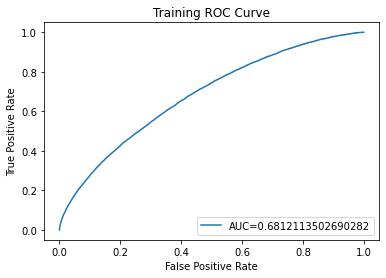

In [297]:
y_pred_proba = model1.predict_proba(x_train)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_train,  y_pred_proba)
auc = metrics.roc_auc_score(y_train, y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.title("Training ROC Curve")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

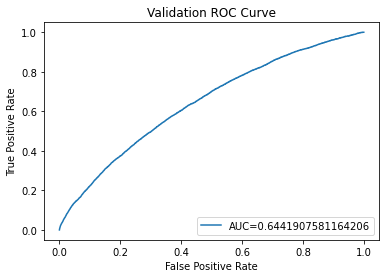

In [309]:
y_pred_proba = model1.predict_proba(x_val)[::,1]
fpr, tpr, thresholds = metrics.roc_curve(y_val,  y_pred_proba)
auc = metrics.roc_auc_score(y_val, y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.title("Validation ROC Curve")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [310]:
f1_scores=[]
cutoffs=np.arange(0,1,0.005)
for i in cutoffs:
    predictions=np.where(y_pred_proba>i,1,0)
    f1_scores.append(f1_score(y_val,predictions))

In [311]:
np.argmax(f1_scores)

21

In [312]:
# Cutoff index
cutoffs[21]

0.105

In [315]:
# Cutoff maximizing f1-score
cutoff_probability=f1_scores[21]

#### Test AUC

In [328]:
# Enquiry Data

f = open('enquiry_data_test.json')
  
# returns JSON object as 
# a dictionary
data = json.load(f)

unq_lst=[]

for val in data:
    unq_lst.extend(val)
    

enquiry_data_test=pd.json_normalize(unq_lst)

In [329]:
# Accounts Data Train

f = open('accounts_data_test.json')
  
# returns JSON object as 
# a dictionary
data_accounts = json.load(f)

unq_lst_accounts=[]

for val in data_accounts:
    unq_lst_accounts.extend(val)
    
accounts_data_test=pd.json_normalize(unq_lst_accounts)

In [330]:
test_flag=pd.read_csv('test_flag.csv')

In [331]:
# Making  features around credit history

# closed_fg-Whether a loan is closed or not: 1 if loan is closed else 0
accounts_data_test['closed_fg']=(~accounts_data_test['closed_date'].isna()).astype(int)
accounts_data_test['closed_fg']=accounts_data_test['closed_fg'].astype(str)
accounts_data_test['closed_fg']=np.where(accounts_data_test['closed_fg']=='0',"open","closed")

# pct_due- % Overdue for each loan =(amount_overdue*100/loan_amount)
accounts_data_test['pct_due']=accounts_data_test['amount_overdue']*100/accounts_data_test['loan_amount']


# Type Casting to date time
accounts_data_test['open_date_1']=pd.to_datetime(accounts_data_test['open_date'])
accounts_data_test['closed_date_1']=pd.to_datetime(accounts_data_test['closed_date'])
accounts_data_test['closed_date_1']=pd.to_datetime(accounts_data_test['closed_date'])


In [332]:
len(accounts_data_test)

220013

In [353]:

# default_mnths_pct-% months member has defaulted in loan repayment period
# default_mnths_pct-% months member has defaulted in last 6 months of loan repayment period

accounts_data_test['default_mnth_history']=accounts_data_test['payment_hist_string'].apply(lambda x : default_mnth_history(x))
accounts_data_test['default_mnths_pct']=accounts_data_test.default_mnth_history.str.count('1')*100/(accounts_data_test.default_mnth_history.str.len())
accounts_data_test['default_mnths_pct_recent']=accounts_data_test.default_mnth_history.apply(lambda x : x[len(x)-6:].count('1')*100/max(min(len(x),6),1))





accounts_data_test['prev_loan_default'] = accounts_data_test.sort_values(by=['open_date'], ascending=True)\
                       .groupby(['uid'])['amount_overdue'].shift(1)


# Feature for Loan Closure date
accounts_data_test['diff_days']=accounts_data_test['closed_date_1']-accounts_data_test['open_date_1']

# Feature for how many days before today - Loan was opened
accounts_data_test['relationship_period']=pd.to_datetime('today')-accounts_data_test['open_date_1']



# Creating binary variable for loan type

accounts_data_test['value']=1

dummies_accounts_data_test=accounts_data_test.pivot_table(values='value',index='uid',aggfunc='max',columns='credit_type').reset_index()



# Augmenting column names for differtiating between feature from loan vs enquiry- 
# _loan features are coming from loan data
cols=[]

cols_aug=[i+'_loan' for i in dummies_accounts_data_test.columns]

dummies_accounts_data_test.columns=cols_aug


## feature for days difference between oldest loan and current date approved for a member

rln_period_test=accounts_data_test.groupby('uid').aggregate({'relationship_period':max}).reset_index()

rln_period_test.relationship_period=rln_period_test.relationship_period.apply(lambda x : x.days )


# Features for closed vs open loan amounts,amount_overdue no of loans taken, 
# % months defaulted over payment period, % months defaulted over last 6 months
# Difference between open and closed days

accounts_data_test_grouped=accounts_data_test.groupby(['uid','closed_fg']).aggregate({'loan_amount':sum,'amount_overdue':sum,'open_date':'count','default_mnths_pct':'max','default_mnths_pct_recent':'max','diff_days':'mean'})

accounts_data_test_grouped.diff_days=accounts_data_test_grouped.diff_days.apply(lambda x : x.days )

# Bringing closed flag to columns 
accounts_data_test_grouped=accounts_data_test_grouped.unstack('closed_fg')

# Renaming Columns due to problems caused by multi level columns
accounts_data_test_grouped.columns=["_".join(x) for x in accounts_data_test_grouped ]

accounts_data_test_grouped=accounts_data_test_grouped.reset_index()




# Loan Amount Features
loan_amt_features_test=accounts_data_test.groupby(['uid','credit_type','closed_fg']).aggregate({'loan_amount':sum,'open_date':'count','default_mnths_pct':'mean','default_mnths_pct_recent':'mean'})

loan_amt_features_test=loan_amt_features_test.unstack(['credit_type','closed_fg']).reset_index()

loan_amt_features_test.columns=["_".join(x) for x in loan_amt_features_test.columns]

loan_amt_features_test.rename(columns = {'uid__':'uid'
                              
                              
                             }, inplace = True)
 
accounts_data_test_grouped=accounts_data_test_grouped.merge(loan_amt_features_test,on='uid')

accounts_data_test_grouped=accounts_data_test_grouped.merge(rln_period_test,on='uid')

accounts_data_test_grouped=accounts_data_test_grouped.merge(dummies_accounts_data_test,left_on='uid',right_on='uid_loan')




# Creating Feature for days between enquiry
# Feature for difference netween days of enquiry

enquiry_data_test['value']=1

enquiry_data_test['next_enq'] = enquiry_data_test.sort_values(by=['enquiry_date'], ascending=True)\
                       .groupby(['uid'])['enquiry_date'].shift(-1)

# enq_diff - Feature for difference between dates of enquiry

enquiry_data_test['next_enq'] = enquiry_data_test.sort_values(by=['enquiry_date'], ascending=True)\
                       .groupby(['uid'])['enquiry_date'].shift(-1)
enquiry_data_test['next_enq']=enquiry_data_test['next_enq'].fillna(pd.to_datetime('today'))
enquiry_data_test['enq_diff_recent']=pd.to_datetime('today')-pd.to_datetime(enquiry_data_test['enquiry_date'])
enquiry_data_test['enq_diff']=pd.to_datetime(enquiry_data_test['next_enq'])-pd.to_datetime(enquiry_data_test['enquiry_date'])

# Converting enquiry amt to float
enquiry_data_test['enquiry_amt']=enquiry_data_test['enquiry_amt'].astype(float)

# taking median of difference of enquiry dates and also creating date from for recent enquiry
enquiry_data_test_diff=enquiry_data_test.groupby('uid').aggregate({"enq_diff":['median'],"enq_diff_recent":['min']}).reset_index()
enquiry_data_test_diff.columns=[ "".join(x) for x in enquiry_data_test_diff.columns]


enquiry_data_test_diff['enq_diffmedian']=enquiry_data_test_diff['enq_diffmedian'].apply(lambda x : x.days)
enquiry_data_test_diff['enq_diff_recentmin']=enquiry_data_test_diff['enq_diff_recentmin'].apply(lambda x : x.days)


# Creating Dummies for Enquiry Type
dummies=enquiry_data_test.pivot_table(values='value',index='uid',aggfunc='max',columns='enquiry_type').reset_index()

# Creating Dummies for Enquiry Amount
enquiry_data_test_pivot=enquiry_data_test.groupby(['uid']).aggregate({'enquiry_amt':"mean",'enquiry_date':'count'}).reset_index()


# Merging all 3 kinds of enquiry features
enquiry_data_test_pivot=pd.merge(enquiry_data_test_pivot,enquiry_data_test_diff,on='uid')

enquiry_data_test_new_features=pd.merge(enquiry_data_test_pivot,dummies,on='uid')

enquiry_data_test_new_features.head()

# Filling missing values
enquiry_data_test_new_features=enquiry_data_test_new_features.fillna(0)



# Mergeing testing data with enquiry features
all_data_test=test_flag.merge(enquiry_data_test_new_features,left_on='uid',right_on='uid',how='left')

# Mergeing testing data with accounts features
all_data_test=all_data_test.merge(accounts_data_test_grouped,left_on='uid',right_on='uid',how='left')




# Creating Dummy variable for Revolving loans 

all_data_test.loc[:,'Revolving loans given']=pd.get_dummies(all_data_test['NAME_CONTRACT_TYPE'],drop_first=True)

# Creating Feature for Open vs Closed Loan Amounts
all_data_test['open_vs_closed']=all_data_test['loan_amount_open']/all_data_test['loan_amount_closed']
all_data_test['open_vs_closed'].replace([np.inf, -np.inf,np.nan], 0, inplace=True)


# Scaling Amounts using log

col=[x for x in all_data_test.columns if 'amount' in x]
col.extend(['enquiry_amt'])

for x in col:
    all_data_test[x]=np.log(all_data_test[x])
    all_data_test[x].replace([np.inf, -np.inf,np.nan], 0, inplace=True)
#     data_scaled = pd.DataFrame(scaler.transform(to_scaled))
#     data_scaled.columns=to_scaled.columns

# all_data_test_scaled.head()

# all_data_test.loc[:,data_scaled.columns]=data_scaled


# Imputing Missing values by 0 
all_data_test=all_data_test.fillna(0)





x_test=all_data_test.loc[:,~all_data_test.columns.isin(['uid_loan','NAME_CONTRACT_TYPE'])].set_index('uid')
# y_test=pd.DataFrame(all_data_test[['TARGET','uid']]).set_index('uid')


# for incorporating feature mismatch between train and test
train_objs_num = len(x_train)
dataset = pd.concat(objs=[x_train, x_test], axis=0)
dataset = pd.get_dummies(dataset)
x_test = dataset[train_objs_num:]


C:\Users\Harsh Surana\OneDrive\Documents\Anaconda\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [360]:
y_pred_proba_test = model1.predict_proba(x_test)[::,1]


In [363]:
max(y_pred_proba_test)

0.57628363

In [364]:
min(y_pred_proba_test)

0.012277392

In [361]:
y_pred_proba_test.shape

(46127,)

In [365]:
test_predictions=[]
predictions_test=np.where(y_pred_proba_test>cutoff_probability,1,0)
    


In [369]:
len(y_pred_proba_test)

46127

In [370]:
test_flag.loc[:,'predictions']=list(predictions_test)

In [371]:
test_flag.head()

,uid,NAME_CONTRACT_TYPE,predictions
0,CMO22835242,Cash loans,0
1,MRJ34316727,Cash loans,0
2,UAV00534378,Cash loans,0
3,IPQ08190402,Cash loans,0
4,NQN84331006,Cash loans,0


In [372]:
test_flag.to_csv('test_predicitons')

### Miscellaneous - Tried Undersampling and SMOTE,SMOTEENN but didn't get superior results

In [ ]:
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler



# summarize class distribution
print("Before undersampling: ", Counter(y_train['TARGET']))

# define undersampling strategy
undersample = RandomUnderSampler(sampling_strategy=0.20)

# fit and apply the transform
X_train_under, y_train_under = undersample.fit_resample(x_train, y_train['TARGET'])

# summarize class distribution
print("After undersampling: ", Counter(y_train_under))

y_train.head()

from imblearn.combine import SMOTEENN

# summarize class distribution
print("Before oversampling: ",Counter(y_train['TARGET']))

# define oversampling strategy
SMOTEENN = SMOTEENN(sampling_strategy=0.50)

# fit and apply the transform
X_train_SMOTE, y_train_SMOTE = SMOTEENN.fit_resample(x_train, y_train['TARGET'])

# summarize class distribution
print("After oversampling: ",Counter(y_train_SMOTE))


X_val_SMOTE, y_val_SMOTE = SMOTEENN.fit_resample(x_val, y_val['TARGET'])
